In [1]:
from torchvision import transforms
from torch.utils.data import DataLoader

from utils.dataset import CustomDataset
from model.aotgan import InpaintGenerator

import utils

import torch
import os
import pandas as pd 
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import matplotlib.pyplot as plt
import cv2
import numpy as np 


In [2]:
ts_img_dir = '/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/WEB/inference/img'
ts_mask_dir = '/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/WEB/inference/mask'

test_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

test_dataset = CustomDataset(
    image_dir = ts_img_dir,
    mask_dir = ts_mask_dir,
    transform= test_transform,
    mask_transform= test_transform,
    testing = True,
    mask_shuffle = False,
)
ts_batch = 16
test_loader = DataLoader(dataset = test_dataset, batch_size = ts_batch, shuffle = False)


('/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/WEB/inference/img/P001.png',)


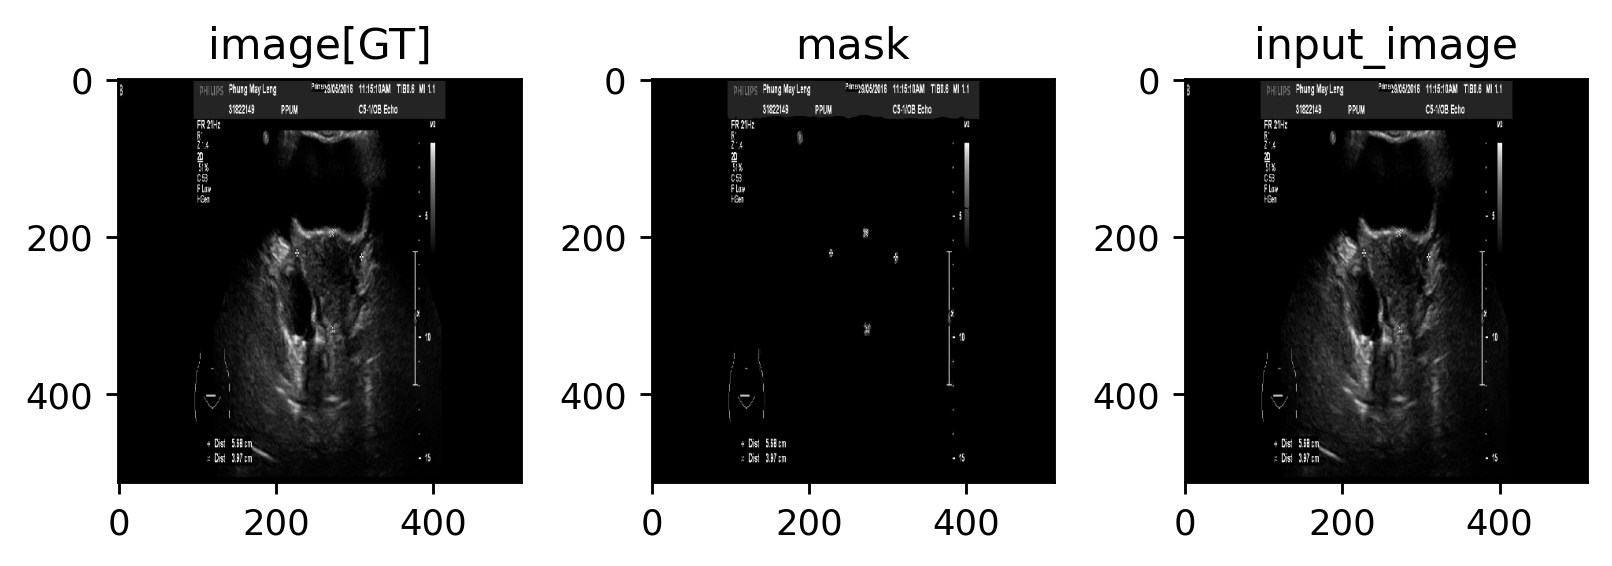

In [4]:
def plotting(images, masks, input_images):
    plt.figure(dpi =256)
    plt.subplot(131)
    plt.imshow(images[0,0], cmap= 'gray')
    plt.title('image[GT]')
    plt.subplot(132)
    plt.imshow(masks[0,0 ], cmap= 'gray')
    plt.title('mask')
    plt.subplot(133)
    plt.imshow(input_images[0,0 ], cmap= 'gray')
    plt.title('input_image')
    plt.tight_layout()
    plt.show()



for images, masks, paths in test_loader:
    print(paths)
    masks = utils.infer_preprocess_mask(images, masks)
    # mask가 0이 아닌 부분에 대해 image를 mask로 대체
    input_images = images.clone()
    # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
    input_images[masks != 0] = masks[masks != 0] 
        
    # input_images 처리해줫으니 다시 masks를 1채널로 변경
    masks = masks[:,0,:,:].unsqueeze(1)
    plotting(images, masks, input_images)
    break


In [9]:
# load_path = '/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/AI/inference/model/weight/OCI-GAN-Generator.pt'
load_path = '/mnt/HDD/oci_models/aotgan/OCI-GAN_v1_240506/model_64.pt'
save_path = '/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/WEB/inference/res'
visual_save_path = '/home/eiden/eiden/capstone/HUFS-BME-AI-WEB/WEB/inference/res_compare'
os.makedirs(save_path, exist_ok= True)
os.makedirs(visual_save_path, exist_ok= True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
netG = InpaintGenerator().to(device)
G_check = torch.load(load_path)['netG_state_dict']
netG.load_state_dict(G_check)



<All keys matched successfully>

In [10]:
with torch.no_grad():

    netG.eval()
    for images, masks, image_paths in test_loader:
        masks = utils.infer_preprocess_mask(images, masks)
        images, masks = images.to(device), masks.to(device)
        ### 전처리
        # mask가 0이 아닌 부분에 대해 image를 mask로 대체
        input_images = images.clone()
        # mask와 input_images shape이 같아야하므로 mask를 image shape으로 resize
        input_images[masks != 0] = masks[masks != 0] 
        # input_images 처리해줫으니 다시 masks를 1채널로 변경
        masks = masks[:,0,:,:].unsqueeze(1)
        # 입력이미지 device 할당
        input_images = input_images.to(device) 

        ### inference
        pred_images = netG(input_images, masks)  # 3+1ch
        
        ## mask에서 0이 아닌 부분을 GT로 대체, 이때 마스크는 0~1사이의 값을 가짐 
        comp_images = images.clone()
        comp_images[masks.repeat(1,3,1,1) != 0] = pred_images[masks.repeat(1,3,1,1) != 0] #comp_image를 남겨두는 이유는 result를 확인하기 위함 

        # metric를 평가하기 위해 metric_images와 pred_images에서 mask와 같은 인덱스인 부분을 제외하고 0으로 만들기 
        metric_gt, metric_pred = images.clone(), pred_images.clone()
        metric_gt[masks.repeat(1,3,1,1) == 0] = 0
        metric_pred[masks.repeat(1,3,1,1) == 0] = 0
        

        #img_save
        for input_image, mask, pred_image, path in zip(input_images, masks, comp_images, image_paths):
            file_name = path.split('/')[-1]
            # Origianl Image 대로 Resize
            original_image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            utils.test_plotting(input_image, mask, pred_image, save_path = os.path.join(visual_save_path, file_name))

            pred_image = pred_image.cpu().detach().numpy()
            # Transpose pred_image from (C, H, W) to (H, W, C) for OpenCV compatibility
            pred_image = np.transpose(pred_image, (1, 2, 0))

            # Now, resize pred_image to match the original image's dimensions
            pred_image = cv2.resize(pred_image, (original_image.shape[1], original_image.shape[0]))  # Note the order of shape
            pred_image = np.clip(pred_image * 255, 0, 255).astype(np.uint8)  # Scale to 0-255 and convert to uint8
            cv2.imwrite(os.path.join(save_path, file_name), pred_image)

# Application External Data Check

1647

206